# Import libraries

In [1]:
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox
import ipywidgets as widgets
import jupyros as jr
import rospy
from std_msgs.msg import String
from jupyros import ros3d
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from tf import transformations

from move_base_msgs.msg import MoveBaseActionGoal
from geometry_msgs.msg import Twist
from sensor_msgs.msg import LaserScan
from actionlib_msgs.msg import GoalID, GoalStatusArray
from nav_msgs.msg import Odometry


from random import seed
from random import randint

from IPython.display import clear_output



# Define variables and publishers

## Modality 1 - Reach a point

In [2]:
global goal_id
global succ_goal
global fail_goal
global total_goal
global goal_in_progress

goal_in_progress = False

succ_goal = 0
fail_goal = 0
total_goal=0

pub_goal = rospy.Publisher("/move_base/goal", MoveBaseActionGoal, queue_size = 1)
pub_cancel = rospy.Publisher("/move_base/cancel", GoalID, queue_size = 1)

## Modality 2 & 3 - Drive the robot (with or without collision avoidance)

In [3]:
global linear
global angular
global lin_speed
global ang_speed
global velocity
global wall_th
global collision_avoidance

linear = 0
angular = 0
lin_speed = 0.5
ang_speed = 1
velocity = Twist()
wall_th = 1
collision_avoidance = False

pub_vel = rospy.Publisher("/cmd_vel", Twist, queue_size = 1)


# Widget Definition

## Initial choose between modalities

In [4]:
output = widgets.Output()

button1 = Button(description='Reach autonomousely a given position',
    tooltip='Reach autonomousely a given position',
layout=Layout(width='33%', height='100px', align="center", grid_area='b1'),
style=ButtonStyle(button_color='lightblue'))

button2 = Button(description='Drive the robot',
    tooltip='Drive the robot',
layout=Layout(width='33%',height='100px', grid_area='b2'),
style=ButtonStyle(button_color='moccasin'))

button3 = Button(description='Drive the robot with collision avoidance',
    tooltip='Drive the robot with collision avoidance',
layout=Layout(width='33%', height='100px', grid_area='b3'),
style=ButtonStyle(button_color='salmon'))

mod_selection = HBox([button1,button2,button3])

## Modality 1 - reach a point

In [5]:
ok_button = Button(description='Send goal',
    tooltip='Send goal',
layout=Layout(width='50%', height='100px', grid_area='b1'),
button_style='info')

cancel_button = Button(description='Cancel goal',
    tooltip='Cancel goal',
layout=Layout(width='50%',height='100px', grid_area='b2'),
button_style='danger')

yes_button = Button(description='Yes',
    tooltip='Set another goal',
layout=Layout(width='50%', height='100px', grid_area='b1'),
button_style='info')

no_button = Button(description='No',
    tooltip='Back to the main manu',
layout=Layout(width='50%',height='100px', grid_area='b2'),
button_style='danger')

goal_x = widgets.FloatText(
    value=0,
    description='X:',
    disabled=False
)
goal_y = widgets.FloatText(
    value=0,
    description='Y:',
    disabled=False
)

continue_box=HBox([yes_button,no_button])
goal_box = HBox([goal_x, goal_y])

## Modality 2 & 3 - Drive the robot (with or without collision avoidance)

In [6]:
lf_button = Button(description='Left-Forward',
    tooltip='Turn left and move forward',
layout=Layout(width='50%', height='40px', grid_area='b1'),
button_style='info')
f_button = Button(description='Forward',
    tooltip='Move forward',
layout=Layout(width='50%', height='40px', grid_area='b1'),
button_style='info')
rf_button = Button(description='Right-Forward',
    tooltip='Turn right and move forward',
layout=Layout(width='50%', height='40px', grid_area='b1'),
button_style='info')

l_button = Button(description='Left',
    tooltip='Turn left',
layout=Layout(width='50%', height='40px', grid_area='b1'),
button_style='info')
stop_button = Button(description='Stop',
    tooltip='Stop moving',
layout=Layout(width='50%', height='40px', grid_area='b1'),
button_style='info')
r_button = Button(description='Right',
    tooltip='Turn right',
layout=Layout(width='50%', height='40px', grid_area='b1'),
button_style='info')

lb_button = Button(description='Left-Backward',
    tooltip='Turn left and move backward',
layout=Layout(width='50%', height='40px', grid_area='b1'),
button_style='info')
b_button = Button(description='Backward',
    tooltip='Move backward',
layout=Layout(width='50%', height='40px', grid_area='b1'),
button_style='info')
rb_button = Button(description='Right-Backward',
    tooltip='Turn right and move backward',
layout=Layout(width='50%', height='40px', grid_area='b1'),
button_style='info')

dec_lin_button = Button(description='Decelerate linear',
    tooltip='Reduce linear velocity by 10%',
layout=Layout(width='50%', height='40px', grid_area='b1'))
reset_lin_button = Button(description='reset linear velocity',
    tooltip='Reset linear velocity',
layout=Layout(width='50%', height='40px', grid_area='b1'))
acc_lin_button = Button(description='Accelerate linear',
    tooltip='Increase linear velocity by 10%',
layout=Layout(width='50%', height='40px', grid_area='b1'))

dec_ang_button = Button(description='Decelerate angular',
    tooltip='Reduce angular velocity by 10%',
layout=Layout(width='50%', height='40px', grid_area='b1'))
reset_ang_button = Button(description='reset angular velocity',
    tooltip='Reset angular velocity',
layout=Layout(width='50%', height='40px', grid_area='b1'))
acc_ang_button = Button(description='Accelerate angular',
    tooltip='Increase angular velocity by 10%',
layout=Layout(width='50%', height='40px', grid_area='b1'))

dec_all_button = Button(description='Decelerate both',
    tooltip='Reduce angular and linear velocity by 10%',
layout=Layout(width='50%', height='40px', grid_area='b1'))
reset_all_button = Button(description='reset both velocity',
    tooltip='Reset angular and linear velocity',
layout=Layout(width='50%', height='40px', grid_area='b1'))
acc_all_button = Button(description='Accelerate both',
    tooltip='Increase angular and linear velocity by 10%',
layout=Layout(width='50%', height='40px', grid_area='b1'))

back_button = Button(description='Back to main menu',
    tooltip='Go back to the initial selection',
layout=Layout(width='100%', height='80px', grid_area='b1'),
button_style='warning')


row1=HBox([lf_button,f_button,rf_button])
row2=HBox([l_button,stop_button,r_button])
row3=HBox([lb_button,b_button,rb_button])

row4=HBox([dec_ang_button,reset_ang_button,acc_ang_button])
row5=HBox([dec_lin_button,reset_lin_button,acc_lin_button])
row6=HBox([dec_all_button,reset_all_button,acc_all_button])

controls = VBox([row1,row2,row3,row4,row5,row6,back_button])

# code of the three modalities

## Define callback functions

### Initial choose between modalities

In [7]:
def modality1(b):
    clear_output(wait=True)
    display(goal_box)
    display(ok_button)
    
def modality2(b):
    clear_output(wait=True)
    display(controls)
    
def modality3(b):
    global collision_avoidance
    collision_avoidance=True
    clear_output(wait=True)
    display(controls)

### Modality 1 - Reach a point

In [8]:
def send_goal(b):
    clear_output(wait=True)
    print("current goal: X=",goal_x.value,", Y=",goal_y.value)
    display(cancel_button)
    
    global goal_in_progress
    goal_in_progress = True
    global goal_id
    goal_id = randint(1000,10000)
    
    goal = MoveBaseActionGoal()

    goal.goal.target_pose.pose.position.x = goal_x.value
    goal.goal.target_pose.pose.position.y = goal_y.value
    goal.goal.target_pose.pose.orientation.w = 1
    goal.goal.target_pose.header.frame_id = "map"
    goal.goal_id.id=str(goal_id)
    
    global total_goal
    
    pub_goal.publish(goal)
    
    total_goal += 1
    
def cancel_goal(b):
    global goal_id
    global goal_in_progress
    
    clear_output(wait=True)
    
    goal_cancel = GoalID()
    goal_cancel.id=str(goal_id)
    pub_cancel.publish(goal_cancel)
    print("goal cancelled!")
    goal_in_progress = False
    print("would you like to set another goal?")
    display(continue_box)

def goal_status_handler(msg):
    global goal_id
    global goal_in_progress
    global succ_goal
    global fail_goal
    
    if goal_in_progress == True:
        
        status=0
        if msg.status_list[0].goal_id.id == str(goal_id):
            status = msg.status_list[0].status

        if status==3:
            clear_output(wait=True)
            
            print("goal reached!")
            succ_goal+=1
            goal_in_progress = False
            print("would you like to set another goal?")
            display(continue_box)
            
        
        if status==4:
            clear_output(wait=True)
            
            print("goal unreachable!")
            fail_goal+=1
            goal_in_progress = False
            print("would you like to set another goal?")
            display(continue_box)
            
def back_to_main_menu_1(b):
    clear_output(wait=True)
    display(mod_selection)



### Modality 2 & 3 - Drive the robot (with or without collision avoidance)

In [9]:
def back_to_main_menu_2_3(b):
    global linear
    global angular
    global lin_speed
    global ang_speed
    global velocity
    global wall_th
    global collision_avoidance
    
    collision_avoidance = False
    linear = 0
    angular = 0
    lin_speed = 0.5
    ang_speed = 1
    
    publish_speed()
    
    clear_output(wait=True)
    display(mod_selection)

def publish_speed():
    global linear
    global angular
    global lin_speed
    global ang_speed
    global velocity
    
    velocity.angular.z=ang_speed*angular
    velocity.linear.x=lin_speed*linear
    
    
    pub_vel.publish(velocity)
    
def lf(b):
    global linear
    global angular
    linear=1
    angular=1
    publish_speed()
    
def f(b):
    global linear
    global angular
    linear=1
    angular=0
    publish_speed()
    
def rf(b):
    global linear
    global angular
    linear=1
    angular=-1
    publish_speed()
    
def l(b):
    global linear
    global angular
    linear=0
    angular=1
    publish_speed()
    
def stop(b):
    global linear
    global angular
    linear=0
    angular=0
    publish_speed()
    
def r(b):
    global linear
    global angular
    linear=0
    angular=-1
    publish_speed()
    
def lb(b):
    global linear
    global angular
    linear=-1
    angular=1
    publish_speed()
    
def b(b):
    global linear
    global angular
    linear=-1
    angular=0
    publish_speed()
    
def rb(b):
    global linear
    global angular
    linear=-1
    angular=-1
    publish_speed()
    
def dec_ang(b):
    global ang_speed
    ang_speed *= 0.9
    publish_speed()
    
def reset_ang(b):
    global ang_speed
    ang_speed = 1
    publish_speed()
    
def acc_ang(b):
    global ang_speed
    ang_speed *= 1.1
    publish_speed()
    
def dec_lin(b):
    global lin_speed
    lin_speed *= 0.9
    publish_speed()
    
def reset_lin(b):
    global lin_speed
    lin_speed = 1
    publish_speed()
    
def acc_lin(b):
    global lin_speed
    lin_speed *= 1.1
    publish_speed()
    
def dec_all(b):
    global lin_speed
    global ang_speed
    lin_speed *= 0.9
    ang_speed *= 0.9
    publish_speed()
    
def reset_all(b):
    global lin_speed
    global ang_speed
    lin_speed = 0.5
    ang_speed = 1
    publish_speed()
    
def acc_all(b):
    global lin_speed
    global ang_speed
    lin_speed *= 1.1
    ang_speed *= 1.1 
    publish_speed()
    
def check_distance(angle_range, min_value, max_value):
    value = 100
    
    for i in range(min_value, max_value):
        if angle_range[i] < value:
            value = angle_range[i]
    return value

def collision_avoidance(msg):
    
    global angular
    global linear
    global velocity
    global wall_th
    global collision_avoidance
    
    if collision_avoidance==True: 
    
        right = check_distance(msg.ranges, 0, 120)
        left = check_distance(msg.ranges, 600, 719)
        front = check_distance(msg.ranges, 290, 410)
    
        if front < wall_th:
            if velocity.linear.x > 0:
                linear = 0
            
        if right < wall_th:
            if velocity.angular.z < 0:
                angular = 0

        if left < wall_th:
            if velocity.angular.z >0:
                angular =0
               
        publish_speed()
    
    
    
    
    

## Associate buttons with callbacks

### Modality 1 - reach a point

In [10]:
button1.on_click(modality1)
ok_button.on_click(send_goal)
cancel_button.on_click(cancel_goal)
yes_button.on_click(modality1)
no_button.on_click(back_to_main_menu_1)

### Modality 2 & 3 - Drive the robot (with or without collision avoidance)

In [11]:
button2.on_click(modality2)
button3.on_click(modality3)

lf_button.on_click(lf)
f_button.on_click(f)
rf_button.on_click(rf)

l_button.on_click(l)
stop_button.on_click(stop)
r_button.on_click(r)

lb_button.on_click(lb)
b_button.on_click(b)
rb_button.on_click(rb)

dec_ang_button.on_click(dec_ang)
reset_ang_button.on_click(reset_ang)
acc_ang_button.on_click(acc_ang)

dec_lin_button.on_click(dec_lin)
reset_lin_button.on_click(reset_lin)
acc_lin_button.on_click(acc_lin)

dec_all_button.on_click(dec_all)
reset_all_button.on_click(reset_all)
acc_all_button.on_click(acc_all)

back_button.on_click(back_to_main_menu_2_3)

# Data Visualization functions

In [12]:
class Visualiser:
    
    def __init__(self):
        self.fig_scan= plt.figure(figsize=(6,6))
        self.ax_scan = plt.subplot(111, polar=True)
        self.ax_scan.set_thetalim(-np.pi/2,np.pi/2)
        self.ax_scan.set_theta_zero_location("N")
        self.laser  = [] 
        self.angles = []
        self.ln_scan, = self.ax_scan.plot([],[],'bo')
        
        self.fig_odom, self.ax_odom = plt.subplots()
        plt.grid(True)
        self.x_pos, self.y_pos = [], []
        self.ln_odom, = plt.plot([] ,[], 'bo')
        
        global succ_goal
        global fail_goal
        global total_goal
        
        self.achieved = False

        self.fig_goal, self.ax_goal = plt.subplots()
        plt.grid(True)
        self.status_list = [0, 0]
        self.data = {'Successful Goals': succ_goal, 
                     'Unreachable Goals': fail_goal, 
                     'Total Goals': total_goal}
        
        self.goal = list(self.data.keys())
        self.values = list(self.data.values())
        self.ln_goal = plt.bar(self.goal, self.values, color=("green", "red", "orange"))
        
    def plot_init(self):
    
        
        self.ax_scan.set_title("Robot Laser Scan")
        self.ax_scan.set_ylabel("Wall distancce",fontweight="bold")
        
        self.ax_odom.set_xlim(-20, 20)
        self.ax_odom.set_ylim(-20, 20)
        self.ax_odom.set_title("Robot Position",fontweight="bold")
        self.ax_odom.set_ylabel("Y",fontweight="bold")
        self.ax_odom.set_xlabel("X",fontweight="bold")

        self.ax_goal.set_ylim(0, 10)
        
        return self.ln_scan , self.ln_odom, self.ln_goal    
        
        
    def laser_scan_callback(self, msg):
        
        self.angles = list(np.arange(msg.angle_min, msg.angle_max+msg.angle_increment, msg.angle_increment))
        self.laser=list(msg.ranges)
        
        
    def odometry_callback(self,msg):
        self.y_pos.append(msg.pose.pose.position.y)
        self.x_pos.append(msg.pose.pose.position.x)
        
    def update_odom_plot(self, frame):
        x = self.x_pos
        y = self.y_pos
        self.ln_odom.set_data(x, y)
        return self.ln_odom
    
    
    def update_goal_plot(self, frame):
        global succ_goal
        global fail_goal
        global total_goal
        
        
        x = total_goal
        y = fail_goal
        z = succ_goal
        self.updated_data = {'Successful Goals': succ_goal, 
                             'Unreachable Goals': fail_goal, 
                             'Total Goals': total_goal}
        
        values = list(self.updated_data.values())
        keys = list(self.updated_data.keys())
        
        self.ln_goal = plt.bar(keys, values, color=("green", "red", "orange"))
        
        return self.ln_goal
    
    def update_polar_plot(self, frame):  
        self.ax_scan.set_rmax(20)
        self.ln_scan.set_data(self.angles,self.laser)
        return self.ln_scan


# Init Ros and Subscribers

In [13]:

rospy.init_node("Assignment")
sub_goal = rospy.Subscriber('/move_base/status', GoalStatusArray, goal_status_handler)
sub_scan = rospy.Subscriber('/scan', LaserScan, collision_avoidance)




# Run code

In [14]:
display(mod_selection)

current goal: X= 4.0 , Y= 1.0


Button(button_style='danger', description='Cancel goal', layout=Layout(grid_area='b2', height='100px', width='…

# Visualize Data

<IPython.core.display.Javascript object>


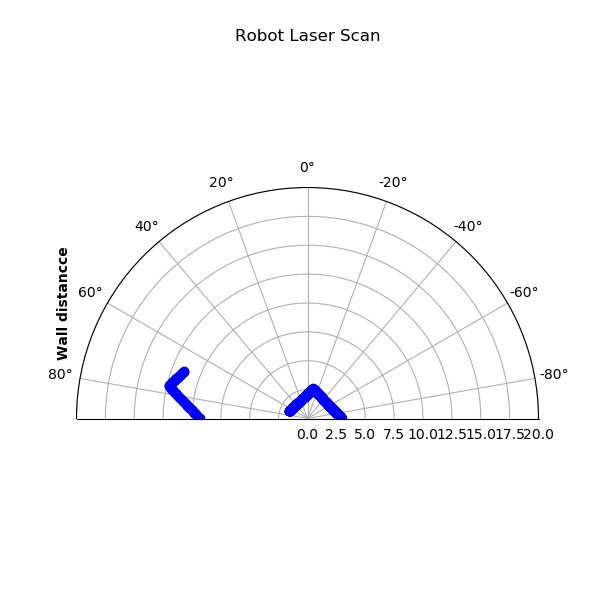

<IPython.core.display.Javascript object>


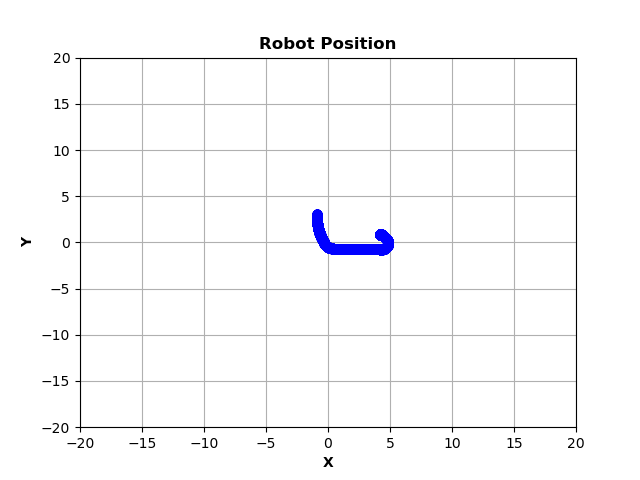

<IPython.core.display.Javascript object>


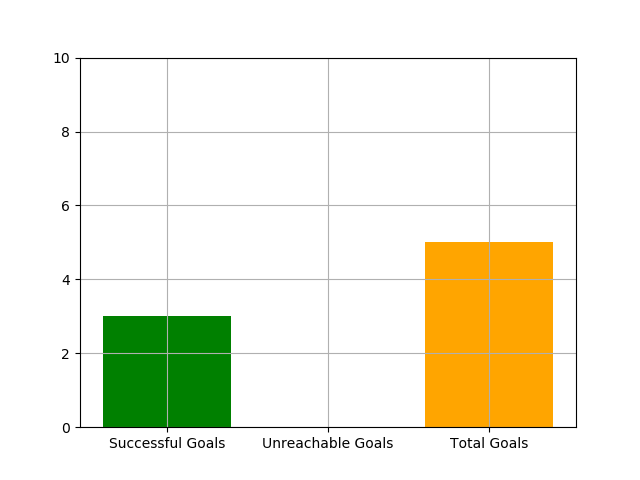

In [15]:
%matplotlib notebook

visualiser = Visualiser()
sub_odom = rospy.Subscriber('/odom', Odometry, visualiser.odometry_callback)
sub_scan2 = rospy.Subscriber('/scan', LaserScan, visualiser.laser_scan_callback)

ani_laser = FuncAnimation(visualiser.fig_scan, visualiser.update_polar_plot, blit = True)
ani_odom = FuncAnimation(visualiser.fig_odom, visualiser.update_odom_plot, init_func=visualiser.plot_init)
ani_target = FuncAnimation(visualiser.fig_goal, visualiser.update_goal_plot, init_func=visualiser.plot_init)

plt.show(block=True)